<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/master/template-report-lab-X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Lab 3: Iterative methods**
**Mathias Axelsson**

# **Abstract**

This report will implement a function for a L2 projection of a function to a piecewise linear approximation over a 1D mesh. In addition a FEM solution for the Poisson's equation will be implemented.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [211]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [212]:
# Load neccessary modules.

import time
import numpy as np
import scipy.integrate as integrate


from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

The L2 projection aproximates the function $f$ by projecting it onto a mesh. 

# **Method**

#### L2 Projection
The L2 projection creates an aproximation of a function $f$ on $L^2([x_0, x_n])$ using the functions 
$$
\phi_i(x) = \begin{cases} 
    \lambda_{k, 1}, & x \in I_k \\
    \lambda_{k+1, 0}, & x \in I_{k+1} \\
    0, &\mathrm{otherwise}
\end{cases}
$$
with
$$
    \lambda_{k, 0} = \frac{x_k - x}{h_k} \quad \lambda_{k, 1} = \frac{x - x_{k-1}}{h_k}
$$
and $I_k = [x_{k-1},x_k]$ for a 1D mesh $[x_0, x_1, \cdots, x_{x-1}, x_n]$. This is done by constructing a matrix equation $A\alpha = b$ with
$$
a_{ij} = (\phi_i, \phi_j), \quad b_i = (f, \phi_i)
$$
The vector $\alpha \in \mathbb{R}^n$ is then the L2 projection of the function.

#### FEM Solution for Poisson's equation
I consider the Poisson equtation 
$$
-u''(x) = f(x), \quad x \in (0, 1)
$$
Following the method in Example 9.12 in the course literature I find that
$$
U(x) = \sum^N_{j=1} U_i\phi_j(x)
$$
With $U_i$ from the matrix equation $A\alpha = b$ with $a_{ij} = a(\phi_j, \phi_i)= \int^1_0\phi_j'(x)\phi_i'(x) dx$ and $b_i = L(\phi_i) = \int^1_0f(x)\phi_i(x) dx$.

In [213]:
def basis_func(x, I):
    """
    Implementation of the basis functions.
    Input:
    x: value of x.
    I: start and end interval [x_k-1, x_k, x_k+1]
    
    Output:
    x: value
    """
    
    
    if x >= I[0] and x <= I[1]:
        return (x - I[0])/(I[1] - I[0])
    elif x >= I[1] and x <= I[2]:
        return (I[2] - x)/(I[2] - I[1])
    else:
        return 0
    
def der_basis_func(x, I):
    """
    Implementation of the basis function derivative.
    Input:
    x: value of x.
    I: start and end interval [x_k-1, x_k, x_k+1]
    
    Output:
    x: value
    """
    
    
    if x >= I[0] and x <= I[1]:
        return 1/(I[1] - I[0])
    elif x >= I[1] and x <= I[2]:
        return -1/(I[2] - I[1])
    else:
        return 0


def L2_projection(f, X):
    """
    Implementation of the L2 projection
    Input:
    f: function
    X: mesh
    
    Output:
    a: L2 projection of f
    """
    
    N = len(X)
    
    A = np.zeros((N,N))
    
    # Edge cases
    A[0, 0] = integrate.quad(lambda x: basis_func(x, np.array([-np.NINF, X[0], X[1]]))**2, X[0], X[1])[0]
    A[N-1, N-1] = integrate.quad(lambda x: basis_func(x, np.array([X[N-2], X[N-1], np.Inf]))**2, X[N-2], X[N-1])[0]
    
    f1 = lambda x: basis_func(x, np.array([-np.NINF, X[0], X[1]]))*basis_func(x, np.array([X[0], X[1], X[2]]))
    offDiag = integrate.quad(f1, X[0], X[1])[0]
    A[0, 1] = offDiag
    A[1, 0] = offDiag
    
    # Construct A
    f1 = lambda x: basis_func(x, np.array([X[N-2], X[N-1], np.Inf]))*basis_func(x, np.array([X[N-3], X[N-2], X[N-1]]))
    offDiag = integrate.quad(f1, X[N-2], X[N-1])[0]
    A[N-1, N-2] = offDiag
    A[N-2, N-1] = offDiag
    
    for i in range(1, N-1):
        A[i, i] = integrate.quad(lambda x: basis_func(x, np.array([X[i-1], X[i], X[i+1]]))**2, X[i-1], X[i+1])[0]
    for i in range(1, N-2):
        f1 = lambda x: basis_func(x, np.array([X[i-1], X[i], X[i+1]]))*basis_func(x, np.array([X[i], X[i+1], X[i+2]]))
        offDiag = integrate.quad(f1, X[i], X[i+1])[0]
        A[i, i+1] = offDiag
        A[i+1, i] = offDiag
    
    b = np.zeros(N)
    
    # Handle edge elements
    b[0] = integrate.quad(lambda x: f(x)*basis_func(x, np.array([-np.NINF, X[0], X[1]])), X[0], X[1])[0]
    b[N-1] = integrate.quad(lambda x: f(x)*basis_func(x, np.array([X[N-2], X[N-1], np.Inf])), X[N-2], X[N-1])[0]
    
    # Construct b
    for k in range(1, N-1):
        b[k] = integrate.quad(lambda x: f(x)*basis_func(x, np.array([X[k-1], X[k], X[k+1]])), X[k-1], X[k+1])[0]
    
    
    a = np.linalg.solve(A, b)
    return a


def poisson_solver(f, X):
    """
    Implementation of a solver for the poisson equation
    -u''(x) = f(x).
    Input:
    f: function
    X: mesh
    
    Output:
    U: The solution u(x) evaluated on the mesh nodes
    """
    
    N = len(X)
    
    A = np.zeros((N,N))
    
    
    f1 = lambda x: der_basis_func(x, np.array([-np.NINF, X[0], X[1]]))*der_basis_func(x, np.array([X[0], X[1], X[2]]))
    offDiag = integrate.quad(f1, X[0], X[1])[0]
    A[0, 1] = offDiag
    
    # Construct A
    f1 = lambda x: der_basis_func(x, np.array([X[N-2], X[N-1], np.Inf]))*der_basis_func(x, np.array([X[N-3], X[N-2], X[N-1]]))
    offDiag = integrate.quad(f1, X[N-2], X[N-1])[0]
    A[N-1, N-2] = offDiag
    
    for i in range(1, N-1):
        A[i, i] = integrate.quad(lambda x: der_basis_func(x, np.array([X[i-1], X[i], X[i+1]]))**2, X[i-1], X[i+1])[0]
    for i in range(1, N-2):
        f1 = lambda x: der_basis_func(x, np.array([X[i-1], X[i], X[i+1]]))*der_basis_func(x, np.array([X[i], X[i+1], X[i+2]]))
        offDiag = integrate.quad(f1, X[i], X[i+1])[0]
        A[i, i+1] = offDiag
        A[i+1, i] = offDiag

    
    b = np.zeros(N)
    
    # Handle edge elements
    b[0] = integrate.quad(lambda x: f(x)*basis_func(x, np.array([-np.NINF, X[0], X[1]])), X[0], X[1])[0]
    b[N-1] = integrate.quad(lambda x: f(x)*basis_func(x, np.array([X[N-2], X[N-1], np.Inf])), X[N-2], X[N-1])[0]
    
    # Construct b
    for k in range(1, N-1):
        b[k] = integrate.quad(lambda x: f(x)*basis_func(x, np.array([X[k-1], X[k], X[k+1]])), X[k-1], X[k+1])[0]
    
    (a, res, _, _) = np.linalg.lstsq(A[:, 1:N-1], b, rcond=None)
    
    U = np.zeros(X.shape)
    U[1:N-1] = a
    
    return U*N
    
    

# **Results**

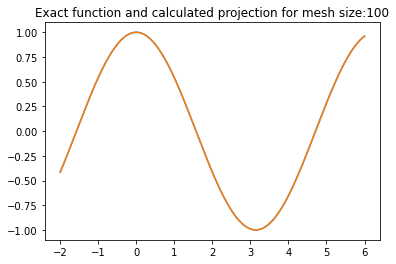

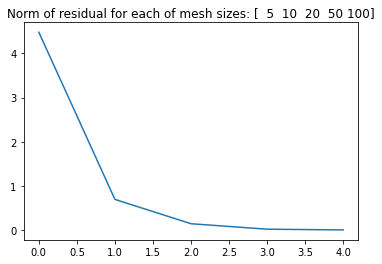

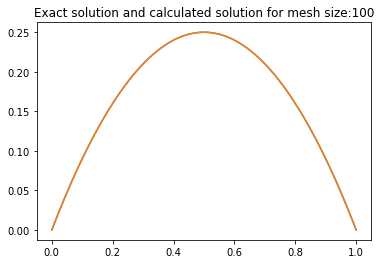

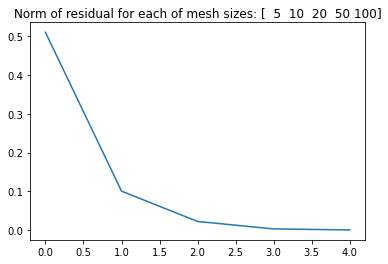

In [214]:
meshSize = np.array([5, 10, 20, 50, 100])
res = np.zeros(meshSize.shape)

# L2 Projection
def f(x):
    return np.cos(x)


for k, s in enumerate(meshSize):
    mesh = np.linspace(-2, 6, num=s)
    X = np.linspace(-2, 6, num=1000)

    N = len(mesh)

    Y = np.zeros(X.shape)

    for i, x in enumerate(X):
        Y[i] = f(x)

    a = L2_projection(f, mesh)

    Y2 = np.zeros(X.shape)
    for i in range(1, N - 1):
        for j,x in enumerate(X):
            Y2[j] += a[i]*basis_func(x, np.array([mesh[i-1], mesh[i], mesh[i+1]])) 

    for j,x in enumerate(X):
        Y2[j] += a[0]*basis_func(x, np.array([-np.NINF, mesh[0], mesh[1]])) 
    for j,x in enumerate(X):
        Y2[j] += a[N-1]*basis_func(x, np.array([mesh[N-2], mesh[N-1], np.Inf]))
        
    res[k] = np.linalg.norm(Y - Y2)


plt.plot(X,Y)
plt.plot(X,Y2)
plt.title("Exact function and calculated projection for mesh size:" + str(s))
plt.show()

plt.plot(res)
plt.title("Norm of residual for each of mesh sizes: " + str(meshSize))
plt.show()

# Poisson equation
def f(x):
    return 2

def sol(x):
    return -x**2 + x

res = np.zeros(meshSize.shape)

for k, s in enumerate(meshSize):
    mesh = np.linspace(0, 1, num=s)
    X = np.linspace(0, 1, num=2000)

    N = len(mesh)
    Y = np.zeros(X.shape)
    for i, x in enumerate(X):
        Y[i] = sol(x)

    U = poisson_solver(f, mesh)
    
    Y2 = np.zeros(X.shape)
    for i in range(1, N - 1):
        for j,x in enumerate(X):
            Y2[j] += U[i]*basis_func(x, np.array([mesh[i-1], mesh[i], mesh[i+1]]))
            
    res[k] = np.linalg.norm(Y - Y2)
    
plt.plot(X, Y2)
plt.plot(X, Y)
plt.title("Exact solution and calculated solution for mesh size:" + str(s))
plt.show()

plt.plot(res)
plt.title("Norm of residual for each of mesh sizes: " + str(meshSize))
plt.show()

# **Discussion**

The functions work as intended. I did not manage to get the Poisson equation solver to work for anything other than an uniform interval. My belief is that I have some sort of scaling issue for each element. I started with a fairly bad implementation of the basis functions which makes the code harder to read than necessary.

The difference between the projection/solution and the exact functions goes to zero as the mesh size increases.